# Data Separation

Author: Gillian A. McGinnis, final-semester M.S. Information Science - Machine Learning  
The University of Arizona College of Information  
INFO 698 - Capstone  
Start date: 21 October 2025  
Last updated: 21 October 2025

In [1]:
"""
Module providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.
"""

'\nModule providing code for test/train split and sliding window creation. Relies on 01_eda.ipynb completion.\n'

## Setup

### Packages

In [2]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# # import matplotlib.ticker as ticker
# import matplotlib.dates as mdates
# import datetime as dt
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score

In [3]:
## (Optional chunk)
# Current session information
import session_info
session_info.show(dependencies=False)

### Data

In [4]:
united_water = pd.read_parquet('data/clean/water.parquet')
united_soil = pd.read_parquet('data/clean/soil.parquet')

## Prepare

## Feature Engineering

In [5]:
# Select columns of interest
data_water = united_water.drop(columns=['raw_rain', 'chk_note_rain', 'chk_fail_rain', 'chk_note_ro', 'chk_fail_ro', 'comment_ro', 'source_ro'])

In [6]:
### Note ###
# Remove this later -- just a smaller subset for feature engineering testing!!
# data_water = data_water['2015-01-01 00:00:00':'2016-12-31 23:59:59']
data_water = data_water['2000-01-01 00:00:00':'2015-12-31 23:59:59']
######

In [7]:
del united_water

### Distance from Event

In [8]:
def since_feat(input_df, input_col):
    output_df = input_df.copy()
    # Create index of instances where there is a data point
    instances = output_df[input_col].notna()
    # Create groupings based on most recent instance
    group_id = instances.cumsum()
    # Exclude the first grouping
    # otherwise it assumes there was an event just prior to the first entry
    group_id = group_id.replace(0, np.nan)
    # Create new column to count number of records since the point
    # which resets to 0 at each new point
    output_df[f"since_{input_col}"] = output_df.groupby(group_id).cumcount()
    return output_df

In [9]:
def minsince_feat(input_df, input_col):
    output_df = input_df.copy()#[input_col].to_frame()
    instances = output_df[input_col].notna()
    # Create groupings based on most recent instance
    group_id = instances.cumsum()
    # Exclude the first grouping
    # otherwise it assumes there was an event just prior to the first entry
    group_id = group_id.replace(0, np.nan)
    # Create new column to count the distance in minutes since the point
    # which resets to 0 at each new point
    output_df['timestamp'] = pd.to_datetime(output_df.index)
    # Get start timestamp of the group
    output_df['ts_start'] = output_df.groupby(group_id)['timestamp'].transform('min')
    # Calculate the distance
    output_df[f"minsince_{input_col}"] = (output_df['timestamp'] - output_df['ts_start']).dt.total_seconds()/60
    # Remove extra cols
    output_df = output_df.drop(columns=['timestamp', 'ts_start'])
    return output_df

#### Calibration
Create feature which tracks how recent a calibration was conducted.

In [10]:
# # since_feat(data_water[['ra_rain', 'raw_ro']], 'ra_rain')
# # data_water[['ra_rain', 'raw_ro']]
# data_w_test = data_water.copy()[['ra_rain', 'raw_ro']]
# data_w_test['ra_rain'] = data_w_test['ra_rain'].replace(0, np.nan)

# data_w_test = since_feat(data_w_test, 'ra_rain')
# data_w_test.head()

In [11]:
# # Create index of instances where there is a calibration point
# cal_instances = data_water['weir_level_cal'].notna()
# # Create groupings based on most recent instance
# cal_group_id = cal_instances.cumsum()
# # Create new column to count number of records since the calibration point
# # which resets to 0 at each new calibration
# data_water['records_since_cal'] = data_water.groupby(cal_group_id).cumcount()

# # Clean up environment
# del cal_instances, cal_group_id

# # data_water

# data_water = since_feat(data_water, 'weir_level_cal')
data_water = minsince_feat(data_water, 'weir_level_cal')

#### Rain
Create feature which tracks how recent a rain event occurred.

In [12]:
# # Create index of instances where there is a calibration point
# rain_instances = data_water['ra_rain'].notna()
# # Create groupings based on most recent instance
# rain_group_id = rain_instances.cumsum()
# # Create new column to count number of records since the calibration point
# # which resets to 0 at each new calibration
# data_water['records_since_rain'] = data_water.groupby(rain_group_id).cumcount()

# # Clean up environment
# del rain_instances, rain_group_id

# # Replace NAs with 0
# data_water['ra_rain'] = data_water['ra_rain'].fillna(0)

# data_water.sample(10)
# # data_water.dropna(subset='raw_ro')

# data_water = since_feat(data_water, 'ra_rain')
data_water = minsince_feat(data_water, 'ra_rain')
# data_water.sample(10)

Fill missing rain values with 0

In [13]:
# data_water['ra_rain'] = data_water['ra_rain'].fillna(0)
# data_water.sample(10)

### Rain event

Keep track of cumulative rainfall during a specific event.

In [14]:
# Create index of instances where there is a data point
rain_event = data_water['ra_rain'].isnull()
rain_event = (data_water['ra_rain'].isnull() & ((data_water['minsince_ra_rain'] >= 5.0) & (data_water['minsince_ra_rain'] != 0)))
# Create groupings based on most recent instance
rain_event_id = rain_event.cumsum()
# Create new column to count number of records since the point
# which resets to 0 at each new point
# del group_id, instances
# water_mini
# group_id = group_id.replace(0, np.nan)
# water_mini['since_ra_rain2'] = water_mini.groupby(group_id).cumcount()
# water_mini
# water_mini.info()
data_water['eventsum_ra_rain'] = data_water.groupby(rain_event_id)['ra_rain'].cumsum()

del rain_event, rain_event_id

In [15]:
# data_water[data_water['minsince_ra_rain'] > 0]
# data_water
# data_water[(data_water['minsince_weir_level_cal'] < 5) & (data_water['minsince_ra_rain'] != 0)]
# data_water[(data_water['minsince_weir_level_cal'] < 5) & (data_water['minsince_ra_rain'] == 2.0)]
# data_water[(data_water['minsince_weir_level_cal'] < 6) & (data_water['eventsum_ra_rain'].notnull())][['ra_rain', 'eventsum_ra_rain','minsince_ra_rain', 'minsince_weir_level_cal']]
# data_water['2008-10-15 00:00:00':'2008-11-04 10:30:00']
# data_water['2006-06-21 09:15:00':'2006-06-21 09:30:00']

In [16]:
# data_water[['ra_rain', 'since_ra_rain', 'rain_event_cumsum']]
# data_water
# 475

In [17]:
# water_mini = data_water.copy()[['weir_level_cal', 'ra_rain', 'raw_ro', 'since_weir_level_cal', 'since_ra_rain']]
# water_mini.sample(10)

In [18]:
# # water_mini = data_water.copy()[['ra_rain', 'level_ro']]
# water_mini = data_water.copy()['ra_rain'].to_frame()
# instances = water_mini['ra_rain'].notna()
# # Create groupings based on most recent instance
# group_id = instances.cumsum()
# # Exclude the first grouping
# # otherwise it assumes there was an event just prior to the first entry
# group_id = group_id.replace(0, np.nan)
# # Create new column to count number of records since the point
# # which resets to 0 at each new point
# # output_df[f"since_{input_col}"] = output_df.groupby(group_id).cumcount()
# # group_id

# water_mini['timestamp'] = pd.to_datetime(water_mini.index)
# water_mini['ts_start'] = water_mini.groupby(group_id)['timestamp'].transform('min')
# water_mini['ts_dist'] = (water_mini['timestamp'] - water_mini['ts_start']).dt.total_seconds()/60
# water_mini

# # water_mini = water_mini.reset_index()
# # water_mini['ts_start'] = water_mini.groupby(group_id)['datetime'].transform('min')
# # water_mini['ts_dist'] = (water_mini['datetime'] - water_mini['ts_start']).dt.total_seconds() / 60
# # water_mini.set_index('datetime')

In [19]:
# # Create index of instances where there is a data point
# instances = water_mini['ra_rain'].notna()
# # Create groupings based on most recent instance
# group_id = instances.cumsum()
# # Create new column to count number of records since the point
# # which resets to 0 at each new point
# # del group_id, instances
# # water_mini
# # group_id = group_id.replace(0, np.nan)
# # water_mini['since_ra_rain2'] = water_mini.groupby(group_id).cumcount()
# # water_mini
# # water_mini.info()
# water_mini['rain_event'] = water_mini.groupby(group_id)['ra_rain'].cumsum()

# # rain_null_mask = water_mini['ra_rain'].isnull()
# # rain_group_id = rain_null_mask.cumsum()
# # water_mini.groupby(rain_group_id)['ra_rain'].cumsum()
# # # rain_null_mask
# # # water_mini['rain_event_cumsum'] = water_mini.groupby(rain_group_id)['ra_rain'].cumsum()

# # # g_id_event = null_mask.cumsum()
# # # water_m['r_event_sum'] = water_m.groupby(g_id_event)['ra_rain'].cumsum()

# # # del rain_null_mask, rain_group_id
# # # data_water['rain_event_sum'] = data_water.groupby(g_id_event)['ra_rain'].cumsum()

In [20]:
# water_mini

In [21]:
# # israin = water_mini['ra_rain'].notna()
# # israin_group_id = israin.cumsum()
# # # g_id
# # water_mini['since_rain_2'] = water_mini.groupby(israin_group_id).cumcount()
# water_mini['dec'] = np.exp(-0.1*water_mini['since_ra_rain'])
# water_mini['rain_fill'] = water_mini['rain_event_cumsum'].ffill()
# # data_u['1_shallow_f'] = data_u['1_shallow'].ffill()
# water_mini['rain_dec'] = (water_mini['rain_fill']*water_mini['dec'])
# # del israin, israin_group_id
# water_mini

### Decay

In [22]:
def decay_feat(input_df, input_col, input_dec_rate = -0.1):
    output_df = input_df.copy()
    # output_df = since_feat(input_df = output_df, input_col = input_col)
    if f"minsince_{input_col}" not in output_df.columns:
        output_df = minsince_feat(input_df = output_df, input_col = input_col)
    
    output_df[f"decayrate{input_dec_rate}_{input_col}"] = np.exp(input_dec_rate * output_df[f"minsince_{input_col}"])
    output_df[f"ffill_{input_col}"] = output_df[input_col].ffill()
    output_df[f"decay{input_dec_rate}_{input_col}"] = (output_df[f"ffill_{input_col}"] * output_df[f"decayrate{input_dec_rate}_{input_col}"])

    return output_df

# water_m = united_water[['raw_ro', 'level_ro', 'ra_rain', 'obstruction_ro']]

# null_mask = water_m['ra_rain'].isnull()
# g_id_event = null_mask.cumsum()
# water_m['r_event_sum'] = water_m.groupby(g_id_event)['ra_rain'].cumsum()

# is_rain = water_m['ra_rain'].notna()
# g_id = is_rain.cumsum()
# # g_id
# water_m['since_rain'] = water_m.groupby(g_id).cumcount()
# water_m['dec'] = np.exp(-0.1*water_m['since_rain'])
# water_m['rain_fill'] = water_m['r_event_sum'].ffill()
# # data_u['1_shallow_f'] = data_u['1_shallow'].ffill()
# water_m['rain_dec'] = (water_m['rain_fill']*water_m['dec'])

In [ ]:
water_mini = data_water.copy()
water_mini['ra_rain'] = water_mini['ra_rain'].fillna(0)

In [ ]:
water_mini = data_water.copy()
water_mini['ra_rain'] = water_mini['ra_rain'].fillna(0)
water_mini = decay_feat(water_mini, 'eventsum_ra_rain')
selected_columns = water_mini.columns[water_mini.columns.str.contains('ra_rain')]
water_mini[selected_columns]

In [23]:
data_water['ra_rain'] = data_water['ra_rain'].fillna(0)
data_water = decay_feat(data_water, 'eventsum_ra_rain')

### Fill rain values

In [ ]:
# data_water.dropna(subset=['obstruction_ro'])

In [ ]:
# Replace NAs in rain with 0s
# data_water['ra_rain'] = data_water['ra_rain'].fillna(0)

### Lag features
Get values from other recent time stamps.

In [24]:
def lag_feats(input_df, input_cols, input_lags):
    output_df = input_df.copy()
    for col in input_cols:
        for lag in input_lags:
            output_df[f"{col}_lag{lag}"] = output_df[col].shift(lag)
    return output_df

In [25]:
# lag_feats(data_water, ['raw_ro'], [1, 2, 3, 24]).dropna(subset='raw_ro')[['raw_ro', 'raw_ro_lag1', 'raw_ro_lag2']]
# lag_feats(data_water, ['raw_ro'], [1, 2, 3, 24]).dropna(subset='raw_ro')[['raw_ro', 'raw_ro_lag1', 'raw_ro_lag24']]

# Columns to get temporal stats on
cols_to_shift = ['raw_ro', 'ra_rain']
# data at 5-min increments -- lag to record values at 5m, 10m, 15m, 30m, 1h, and 2h prior
lags_of_interest = [1, 2, 3, 6, 12, 24]

data_water = lag_feats(data_water, cols_to_shift, lags_of_interest)

data_water.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,minsince_weir_level_cal,...,raw_ro_lag3,raw_ro_lag6,raw_ro_lag12,raw_ro_lag24,ra_rain_lag1,ra_rain_lag2,ra_rain_lag3,ra_rain_lag6,ra_rain_lag12,ra_rain_lag24
datetime,,,,,,,,,,,,,,,,,,,,,
2011-05-15 18:30:00,NaN,0.0,48.7,48.7,False,False,False,False,False,3450.0,...,51.0,35.9,33.8,34.2,0.0,0.254,0.0,0.762,0.508,0.0
2011-02-18 17:20:00,NaN,0.0,26.6,26.6,False,False,False,False,False,464.0,...,26.5,26.6,26.2,27.2,0.0,0.000,0.0,0.000,0.000,0.0
2010-09-15 03:10:00,NaN,0.0,77.7,77.7,False,False,False,False,False,1094.0,...,77.8,77.8,78.0,78.4,0.0,0.000,0.0,0.000,0.000,0.0
2001-01-06 19:55:00,NaN,0.0,63.3,63.3,False,False,False,False,False,659.0,...,62.7,63.1,62.9,63.2,0.0,0.000,0.0,0.000,0.000,0.0
2008-06-01 23:50:00,NaN,0.0,11.8,11.8,False,False,False,False,False,3724.0,...,11.7,11.7,11.6,11.2,0.0,0.000,0.0,0.000,0.000,0.0
2007-01-13 02:10:00,NaN,0.0,37.9,37.9,False,False,False,False,False,1014.0,...,38.4,39.3,39.3,39.0,0.0,0.000,0.0,0.000,0.000,0.0
2011-04-17 04:15:00,NaN,0.0,12.0,12.0,False,False,False,False,False,2589.0,...,12.0,11.8,12.1,11.9,0.0,0.000,0.0,0.000,0.000,0.0
2012-09-09 07:25:00,NaN,0.0,41.9,41.9,False,False,False,False,False,2784.0,...,42.2,42.3,42.5,39.7,0.0,0.000,0.0,0.000,0.000,0.0
2001-05-17 18:00:00,NaN,0.0,10.4,10.4,False,False,False,False,False,474.0,...,10.6,10.4,10.6,12.0,0.0,0.000,0.0,0.000,0.000,0.0


### Rolling stats

Get stat values from range of recent time stamps.

In [26]:
def rolling_feats(input_df, input_cols, input_windows):
    output_df = input_df.copy()
    for col in input_cols:
        for window in input_windows:
            output_df[f"{col}_rollmean_{window}"] = output_df[col].rolling(window).mean()
            output_df[f"{col}_rollstd_{window}"] = output_df[col].rolling(window).std()
            output_df[f"{col}_rollslope_{window}"] = (output_df[col].rolling(window).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0], raw=True))
    return output_df

In [27]:
# data_water_mini = data_water['1990-01-01 00:00:00':'1990-01-30 23:59:59']
# rolling_feats(data_water_mini, cols_to_lag, [6, 12, 36])
# 10m, 30m, 1h, 6h
windows_of_interest = [2, 6, 12, 72]


data_water = rolling_feats(data_water, cols_to_shift, windows_of_interest)

data_water.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,minsince_weir_level_cal,...,ra_rain_rollslope_2,ra_rain_rollmean_6,ra_rain_rollstd_6,ra_rain_rollslope_6,ra_rain_rollmean_12,ra_rain_rollstd_12,ra_rain_rollslope_12,ra_rain_rollmean_72,ra_rain_rollstd_72,ra_rain_rollslope_72
datetime,,,,,,,,,,,,,,,,,,,,,
2003-07-20 06:15:00,NaN,0.000,48.0,48.0,False,False,False,False,False,2724.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2001-05-28 12:25:00,NaN,0.000,11.0,11.0,False,False,False,False,False,3090.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-12-18 04:20:00,NaN,0.000,52.7,104.5,True,False,False,False,False,4029.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-22 11:30:00,NaN,0.000,33.4,33.4,False,False,False,False,False,165.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-05-02 07:20:00,NaN,1.524,0.0,0.0,False,False,False,False,False,5682.0,...,-0.508,0.762000,0.894426,0.420914,0.381000,0.722491,0.147427,0.067028,0.318997,0.005272
2001-10-01 04:35:00,NaN,0.000,33.9,33.9,False,False,False,False,False,2620.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2008-03-31 21:50:00,NaN,0.000,8.0,8.0,False,False,False,False,False,784.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2006-02-13 11:40:00,NaN,0.000,21.9,21.9,False,False,False,False,False,110.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-10-10 08:05:00,NaN,0.000,50.7,50.7,False,False,False,False,False,1390.0,...,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Change since last value

In [28]:
data_water['raw_ro_change'] = data_water['raw_ro'].diff()

# cal_na_mask = data_water['weir_level_cal'].notna() & data_water['raw_ro'].notna()
# # cal_na_mask
# (data_water['weir_level_cal'] - data_water['raw_ro']).dropna()
# del cal_na_mask
data_water['diff_ro_cal'] = (data_water['weir_level_cal'] - data_water['raw_ro'])
# data_water['rain_diff']

In [ ]:
data_water.sample(10)

## Soil

Pivot the soil data such that each sample has its own columns, and separated by depth.

In [29]:
# Drop irrelevant column
data_soil_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
# Pivot wider
data_soil_shallow = data_soil_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

# Drop irrelevant column
data_soil_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)
# Pivot wider
data_soil_deep = data_soil_deep.pivot(columns='sample', values='h2o_by_wet_deep')

# Combine
data_soil = pd.merge(
    data_soil_shallow,
    data_soil_deep,
    left_index = True,
    right_index = True,
    suffixes = ("_shallow", "_deep"),
    how = "outer"
)

del data_soil_shallow, data_soil_deep

data_soil.sample(10)

sample,1_shallow,2_shallow,3_shallow,4_shallow,5_shallow,6_shallow,7_shallow,8_shallow,9_shallow,10_shallow,1_deep,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep
date,,,,,,,,,,,,,,,,,,,,
1992-04-30,35.9,37.4,37.9,37.6,41.7,32.4,33.8,34.5,33.7,32.4,36.2,37.5,34.4,35.0,37.2,30.9,31.4,30.1,32.3,30.5
2018-04-06,33.6,32.7,42.1,32.8,36.1,37.9,31.5,40.2,29.1,29.3,35.7,33.5,42.5,35.3,35.2,42.4,32.2,29.7,29.9,27.9
1990-02-02,30.9,32.6,34.3,34.6,38.0,29.0,37.0,35.0,27.1,27.2,31.8,32.6,27.4,32.2,36.9,27.9,33.0,25.8,29.7,27.6
2003-01-23,26.9,35.3,35.3,36.4,38.8,39.9,34.6,35.4,29.0,29.0,29.7,36.3,29.9,33.6,29.5,39.2,33.3,21.9,28.8,27.3
1997-04-07,27.1,31.7,27.3,28.8,30.7,26.9,28.0,31.4,25.9,26.9,29.0,33.4,30.9,28.2,31.4,24.4,32.4,20.1,26.7,26.4
2015-01-14,34.4,29.7,36.3,30.8,36.2,36.1,30.4,38.2,28.8,27.9,34.8,33.2,35.9,33.1,36.5,40.0,31.4,29.3,30.2,27.7
1991-02-21,31.1,36.6,31.3,34.7,37.1,31.5,32.1,36.9,26.8,28.4,30.2,33.0,27.8,30.2,35.2,27.1,29.1,25.2,28.0,26.0
2010-01-14,39.7,37.9,48.6,35.8,42.7,41.2,37.0,43.2,28.6,33.0,35.2,32.0,32.2,33.0,37.3,38.8,34.6,31.3,27.9,26.8
2019-07-18,36.1,34.1,44.1,37.9,36.7,40.5,37.0,40.0,36.4,35.3,32.5,32.8,40.7,29.0,32.6,40.1,42.6,44.9,35.7,40.7


In [ ]:
# soil_mini_shallow = united_soil.copy().drop('h2o_by_wet_deep', axis=1)
# soil_mini_shallow = soil_mini_shallow.pivot(columns='sample', values='h2o_by_wet_shallow')

# soil_mini_deep = united_soil.copy().drop('h2o_by_wet_shallow', axis=1)
# soil_mini_deep = soil_mini_deep.pivot(columns='sample', values='h2o_by_wet_deep')

# soil_mini = pd.merge(
#     soil_mini_shallow,
#     soil_mini_deep,
#     left_index=True,
#     right_index=True,
#     # soil_mini_shallow.reset_index(),
#     # soil_mini_deep.reset_index(),
#     # on = ["date", "sample"],
#     suffixes = ("_shallow", "_deep"),
#     how = "outer"
#     )

# soil_mini.head()

## Unite

In [ ]:
# data_u_test = pd.merge(
#     data_water,
#     data_soil['2015-01-01 00:00:00':'2016-12-31 23:59:59'],
#     left_index = True,
#     right_index = True,
#     how = 'outer'
# )

# data_u_test

In [ ]:
# # def since_feat(input_df, input_col):
# #     output_df = input_df.copy()
# #     # Create index of instances where there is a data point
# #     instances = output_df[input_col].notna()
# #     # Create groupings based on most recent instance
# #     group_id = instances.cumsum()
# #     # Create new column to count number of records since the point
# #     # which resets to 0 at each new point
# #     output_df[f"since_{input_col}"] = output_df.groupby(group_id).cumcount()
# #     return output_df

# cols_soil = [col for col in data_u_test.columns if (col.endswith('shallow') | col.endswith('deep'))]
# soil_instances = data_u_test[cols_soil].notna()
# soil_group_id = soil_instances.cumsum().max(axis=1)
# data_u_test["since_soil"] = data_u_test.groupby(soil_group_id).cumcount()
# # data_u_test.groupby(soil_group_id).cumcount()
# # data_u_test["since_soil"] = data_u_test.groupby(soil_group_id).cumcount()
# # data_u_test[cols_soil].notna().cumsum().max(axis=1)

In [30]:
data_united = pd.merge(
    data_water,
    # REMOVE LATER
    # data_soil['2015-01-01 00:00:00':'2016-12-31 23:59:59'],
    data_soil['2000-01-01 00:00:00':'2015-12-31 23:59:59'],
    # data_soil,
    #
    left_index = True,
    right_index = True,
    how = 'outer'
)

In [31]:
# Create feature to track soil value staleness
cols_soil = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]
soil_instances = data_united[cols_soil].notna()
soil_group_id = soil_instances.cumsum().max(axis=1)
data_united["since_soil"] = data_united.groupby(soil_group_id).cumcount()

del soil_instances, soil_group_id

In [32]:
# Extend soil vals
# cols_to_fill = [col for col in data_united.columns if (col.endswith('shallow') | col.endswith('deep'))]
# data_united[cols_to_fill] = data_united[cols_to_fill].ffill()
data_united[cols_soil] = data_united[cols_soil].ffill()

del cols_soil
data_united.sample(10)

,weir_level_cal,ra_rain,level_ro,raw_ro,obstruction_ro,gap_fill_ro,weir_cleaning_ro,spike_ro,calibration_ro,minsince_weir_level_cal,...,2_deep,3_deep,4_deep,5_deep,6_deep,7_deep,8_deep,9_deep,10_deep,since_soil
2001-03-31 03:55:00,NaN,0.000,13.2,13.2,False,False,False,False,False,1114.0,...,36.7,28.0,27.3,35.4,37.4,31.4,19.7,28.3,26.2,336
2012-04-04 18:40:00,NaN,0.000,12.0,12.0,False,False,False,False,False,2034.0,...,28.5,33.8,28.4,34.2,36.7,29.9,20.2,27.9,26.7,1955
2002-02-15 07:00:00,NaN,0.000,25.8,25.8,False,False,False,False,False,1365.0,...,37.0,32.0,24.9,37.2,26.8,29.5,30.1,29.4,27.9,372
2003-06-09 12:20:00,NaN,0.762,90.9,90.9,False,False,False,False,False,139.0,...,34.9,33.3,31.0,35.1,39.5,34.6,31.4,29.2,30.9,1302
2007-05-02 17:25:00,NaN,0.000,54.1,54.1,False,False,False,False,False,7719.0,...,36.7,30.9,33.9,36.0,36.9,36.6,28.5,29.8,29.4,1939
2010-12-17 22:15:00,NaN,0.000,85.4,85.4,False,False,False,False,False,784.0,...,35.6,39.6,39.3,39.5,44.7,39.5,29.8,32.0,32.5,2289
2012-10-31 07:35:00,NaN,0.000,84.2,84.2,False,False,False,False,False,1309.0,...,40.9,39.4,34.7,40.6,44.5,41.6,28.7,35.0,30.8,1768
2009-10-24 09:45:00,NaN,0.000,62.3,62.3,False,False,False,False,False,1484.0,...,36.4,37.5,37.4,40.4,41.5,36.8,32.8,34.9,31.5,695
2000-12-08 08:45:00,NaN,0.000,132.3,132.3,False,False,False,False,False,2881.0,...,39.2,32.3,34.5,40.9,35.6,34.9,36.9,30.2,29.3,4140
2006-07-03 21:00:00,NaN,0.000,29.7,29.7,False,False,False,False,False,684.0,...,36.7,37.5,39.6,41.6,43.6,38.5,24.9,32.2,31.1,3427


### Train/Test (80/20)

In [33]:
# # mini_xy = water_mini[['level_ro', 'raw_ro', 'chk_note_ro', 'source_ro']].dropna()
# mini_xy = water_mini.copy().drop('level_ro', axis=1).dropna()
# mini_y = mini_xy['obstruction_ro']
# # mini_x = mini_xy[['raw_ro', 'chk_note_ro', 'source_ro']]
# mini_x = mini_xy.drop('obstruction_ro', axis=1)
# mini_xy
var_of_interest = 'obstruction_ro'
y_drops = ['level_ro', 'obstruction_ro', 'gap_fill_ro', 'weir_cleaning_ro', 'spike_ro', 'calibration_ro']

data_filtered = data_united.copy().dropna(subset = var_of_interest)
# y_drops.remove(var_of_interest)

united_y = data_filtered[var_of_interest]
# united_x = data_united.drop([var_of_interest, 'level_ro'], axis=1)
united_x = data_filtered.drop(y_drops, axis=1)
# united_x.info()

del data_filtered

# united_x.info()

# united_x.info()

In [34]:
print("Test:\t20p of", len(united_y), "is", round(.2*len(united_y)))
print("Train:\t80p of", len(united_y), "is", round(.8*len(united_y)))
print(round(.2*len(united_y)) + round(.8*len(united_y)))

# mini_x.index[1]

Test:	20p of 1486142 is 297228
Train:	80p of 1486142 is 1188914
1486142


In [35]:
x_train, x_test, y_train, y_test = train_test_split(united_x, united_y, test_size = 0.2, shuffle=False)

print(
    "Train:\t", len(x_train), "\t", x_train.index[0], "thru", x_train.index[-1],
    "\nTest:\t", len(x_test), "\t\t", x_test.index[0], "thru", x_test.index[-1]
    # len(x_train), len(x_test), "\n",
    # x_train.index[-1]
)

Train:	 1188913 	 2000-01-12 14:55:00 thru 2011-06-18 18:00:00 
Test:	 297229 		 2011-06-18 18:05:00 thru 2015-12-31 23:55:00


### Sliding Window

In [36]:
tscv = TimeSeriesSplit(n_splits=20)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=20, test_size=None)


In [ ]:
# print(tscv)
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    # print("  Train: index=", mini_x.index[train_index])
    # print(f"  Test:  index={val_index}")
    print("--------------------------------------------------")

del i, train_index, val_index

In [ ]:
# val_tracker = y_train.copy().to_frame()
# val_tracker['pred'] = .5
# val_tracker.head()

In [ ]:
# # preds
# y_t = y_t.to_frame()
# y_t['preds'] = preds
# pd.concat(y_t)

## Model

In [37]:
# tscv = TimeSeriesSplit(n_splits=15)
# val_tracker = y_train.copy()
# val_tracker['pred'] = .5
# val_tracker = y_train.copy().to_frame()
val_tracker = pd.DataFrame()
win_tracker = pd.DataFrame(columns=["fold", "mse", "rmse", "f1", "acc"])
i = 0

for train_index, val_index in tscv.split(x_train):
    x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
    y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    if len(y_t.unique()) != 2:
        print("Skipping fold", i)
        i += 1
        continue
    # model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
    # model = xgb.XGBClassifier(enable_categorical=True, tree_method="hist")
    # model = xgb.XGBClassifier(tree_method="hist")
    model = xgb.XGBClassifier(
        tree_method="hist",
        # learning_rate=0.1,
        # max_depth=5,
        random_state=42,
        # handle class imbalance -- sum(negative instances) / sum(positive instances)
        scale_pos_weight = (y_t.value_counts()[False] / y_t.value_counts()[True]).item()
    )
    # if len(y_val.unique()) != 2:
    #     print("Skipping fold", i)
    #     i += 1
    #     continue
    # i += 1
    model.fit(x_t, y_t)
    preds = model.predict(X_val)
    #
    y_val_out = y_val.copy().to_frame()
    y_val_out['pred'] = preds
    y_val_out['pred_tf'] = np.where(y_val_out['pred'] == 1, True, False)
    val_tracker = pd.concat([val_tracker, y_val_out])
    #
    mse = mean_squared_error(y_val, preds)
    f1 = f1_score(y_val_out[var_of_interest].tolist(), y_val_out['pred_tf'].tolist())
    accuracy = accuracy_score(y_val_out[var_of_interest].tolist(), y_val_out['pred_tf'].tolist())
    # print("Validation RMSE:", mean_squared_error(y_val, preds, squared=False))
    print(i, "\tMSE:", round(mse, 4), "\tRMSE:", round(np.sqrt(mse), 4), "\tF1:", round(f1, 4), "\tAcc:", round(accuracy, 4))
    win_tracker.loc[len(win_tracker)] = {"fold":i, "mse": mse, "rmse": np.sqrt(mse), "f1": f1, "acc": accuracy}
    i += 1

# val_tracker['pred_tf'] = np.where(val_tracker['pred'] >= 0.5, True, False)

del i, x_t, X_val, y_t, y_val, model, preds, mse, f1, accuracy

Skipping fold 0
1 	MSE: 0.0038 	RMSE: 0.0613 	F1: 0.0 	Acc: 0.9962
2 	MSE: 0.0028 	RMSE: 0.0528 	F1: 0.0 	Acc: 0.9972
3 	MSE: 0.0008 	RMSE: 0.0285 	F1: 0.0 	Acc: 0.9992
4 	MSE: 0.0007 	RMSE: 0.0269 	F1: 0.0 	Acc: 0.9993
5 	MSE: 0.0022 	RMSE: 0.0468 	F1: 0.0 	Acc: 0.9978


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


6 	MSE: 0.0 	RMSE: 0.0 	F1: 0.0 	Acc: 1.0
7 	MSE: 0.0089 	RMSE: 0.0943 	F1: 0.0 	Acc: 0.9911
8 	MSE: 0.0237 	RMSE: 0.1538 	F1: 0.0 	Acc: 0.9763


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


9 	MSE: 0.0 	RMSE: 0.0 	F1: 0.0 	Acc: 1.0
10 	MSE: 0.2538 	RMSE: 0.5037 	F1: 0.0008 	Acc: 0.7462
11 	MSE: 0.0812 	RMSE: 0.285 	F1: 0.0624 	Acc: 0.9188
12 	MSE: 0.0882 	RMSE: 0.2969 	F1: 0.0864 	Acc: 0.9118
13 	MSE: 0.1487 	RMSE: 0.3857 	F1: 0.4521 	Acc: 0.8513
14 	MSE: 0.207 	RMSE: 0.455 	F1: 0.2473 	Acc: 0.793
15 	MSE: 0.203 	RMSE: 0.4506 	F1: 0.4978 	Acc: 0.797
16 	MSE: 0.1296 	RMSE: 0.36 	F1: 0.5027 	Acc: 0.8704
17 	MSE: 0.2219 	RMSE: 0.471 	F1: 0.5148 	Acc: 0.7781
18 	MSE: 0.1104 	RMSE: 0.3323 	F1: 0.4022 	Acc: 0.8896
19 	MSE: 0.14 	RMSE: 0.3741 	F1: 0.4612 	Acc: 0.86


In [ ]:
val_tracker.head()

In [38]:
print(round(win_tracker, 4))

    fold     mse    rmse      f1     acc
0      1  0.0038  0.0613  0.0000  0.9962
1      2  0.0028  0.0528  0.0000  0.9972
2      3  0.0008  0.0285  0.0000  0.9992
3      4  0.0007  0.0269  0.0000  0.9993
4      5  0.0022  0.0468  0.0000  0.9978
5      6  0.0000  0.0000  0.0000  1.0000
6      7  0.0089  0.0943  0.0000  0.9911
7      8  0.0237  0.1538  0.0000  0.9763
8      9  0.0000  0.0000  0.0000  1.0000
9     10  0.2538  0.5037  0.0008  0.7462
10    11  0.0812  0.2850  0.0624  0.9188
11    12  0.0882  0.2969  0.0864  0.9118
12    13  0.1487  0.3857  0.4521  0.8513
13    14  0.2070  0.4550  0.2473  0.7930
14    15  0.2030  0.4506  0.4978  0.7970
15    16  0.1296  0.3600  0.5027  0.8704
16    17  0.2219  0.4710  0.5148  0.7781
17    18  0.1104  0.3323  0.4022  0.8896
18    19  0.1400  0.3741  0.4612  0.8600


In [ ]:
# val_tracker.head()
# y_val.to_list()
# y_val_out['obstruction_ro']
# f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
# f1_score(y_val_out['obstruction_ro'], y_val_out['pred_tf'])
# y_val_out['pred_tf'].tolist()

In [39]:
for i, (train_index, val_index) in enumerate(tscv.split(x_train)):
    continue
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={val_index}")

# print(train_index, "\n", val_index)

x_t, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

# model = xgb.XGBRegressor(enable_categorical=True, tree_method="hist")
model = xgb.XGBClassifier(
    # enable_categorical=True,
    random_state=42,
    scale_pos_weight = (y_t.value_counts()[False] / y_t.value_counts()[True]).item(),
    tree_method="hist"
    )
model.fit(x_t, y_t)

preds = model.predict(X_val)
mse = mean_squared_error(y_val, preds)
# f1 = f1_score(y_val_out['obstruction_ro'].tolist(), y_val_out['pred_tf'].tolist())
print("Validation MSE:", mse, "\tRMSE:", np.sqrt(mse))

del i, train_index, val_index

Validation MSE: 0.13996537958808775 	RMSE: 0.37411947234551657


In [40]:
# f1_score(y_val, preds)
# preds[1]
# y_val_out2 = pd.DataFrame()
y_val_out2 = y_val.copy().to_frame()
y_val_out2['pred'] = preds
y_val_out2['pred_tf'] = np.where(y_val_out2['pred'] == 1, True, False)
f1_score(y_val_out2[var_of_interest].tolist(), y_val_out2['pred_tf'].tolist())

# del y_val_out2

0.4612455806363884

In [41]:
mini_val = y_val.copy()
mini_val = mini_val.reset_index()
mini_val['pred'] = preds
mini_val.set_index('index')
mini_val['pred_tf'] = np.where(mini_val['pred'] == 1, True, False)
mini_val.head()

,index,obstruction_ro,pred,pred_tf
0,2010-11-30 05:45:00,False,0,False
1,2010-11-30 05:50:00,False,0,False
2,2010-11-30 05:55:00,False,0,False
3,2010-11-30 06:00:00,False,0,False
4,2010-11-30 06:05:00,False,0,False


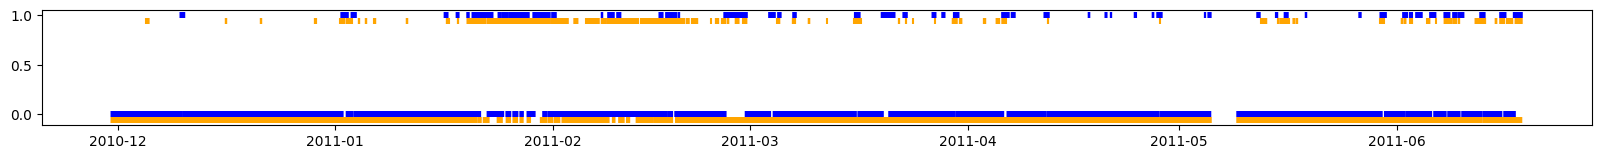

In [42]:
fig, ax = plt.subplots(figsize=(20, 1.5))
ax.scatter(mini_val['index'], mini_val[var_of_interest], s=25, color='blue', marker="|")
ax.scatter(mini_val['index'], mini_val['pred_tf']-.06, s=25, color='orange', marker="|")

plt.show()

del fig, ax

In [43]:
def plot_preds(input_date_start, input_date_end, include_preds=True, include_calibration=True):
    """Plot values between two dates in the style of the Visual FoxPro interface.

    Args:
        input_date_start (Timestamp): The start date.
        input_date_end (Timestamp): The end date.
        include_calibration (boolean): Include X-markers for the calibration points.
    
    Returns:
        Time series plot.
    """
    # Filter the data sets
    data_subset = data_united.copy()[input_date_start:input_date_end]
    # data_subset_rain = data_rainfall.loc[input_date_start:input_date_end]
    # data_subset_cal = data_calibration.loc[input_date_start:input_date_end]

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.axhline(y=0, color ='grey', linestyle = ':')
    # Plot the rain as a bar chart with a multiplier for visibility
    ax.vlines(data_subset.index, ymin=0, ymax=data_subset['ra_rain']*3, color = 'blue', label = "Rain (x3)")
    ax.plot(data_subset.index, data_subset['level_ro'], color = 'red', label = "Adjusted")
    ax.plot(data_subset.index, data_subset['raw_ro'], color = 'green', label = "Raw")
    # Include calibration points unless otherwise specified or unless there are none in the subset
    if include_calibration == True and not data_subset['weir_level_cal'].empty:
        ax.plot(data_subset.index, data_subset['weir_level_cal'], linestyle='none', marker='x', color='red', label = "Calibration")
    if include_preds == True:
        mini_val_subset = mini_val.copy().set_index('index')[input_date_start:input_date_end]
        ax.scatter(mini_val_subset.index, (mini_val_subset[var_of_interest]-3)*10, color='blue', marker="|")
        ax.scatter(mini_val_subset.index, (mini_val_subset['pred_tf']-5)*10, color='orange', marker="|")

    # Plot labels
    ax.set_xlabel("Date (YYYY-MM-DD)")
    ax.set_ylabel("Level (mm)")
    # ax.set_title('Simple Time Series Plot')
    ax.set_title("Runoff time series from " + str(input_date_start) + " through " + str(input_date_end))
    # ax.set_ylim(bottom=0) 
    # ax.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    # Reverse the order of the legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper right')
    # plt.legend(loc = 'upper right')
    return plt.show()

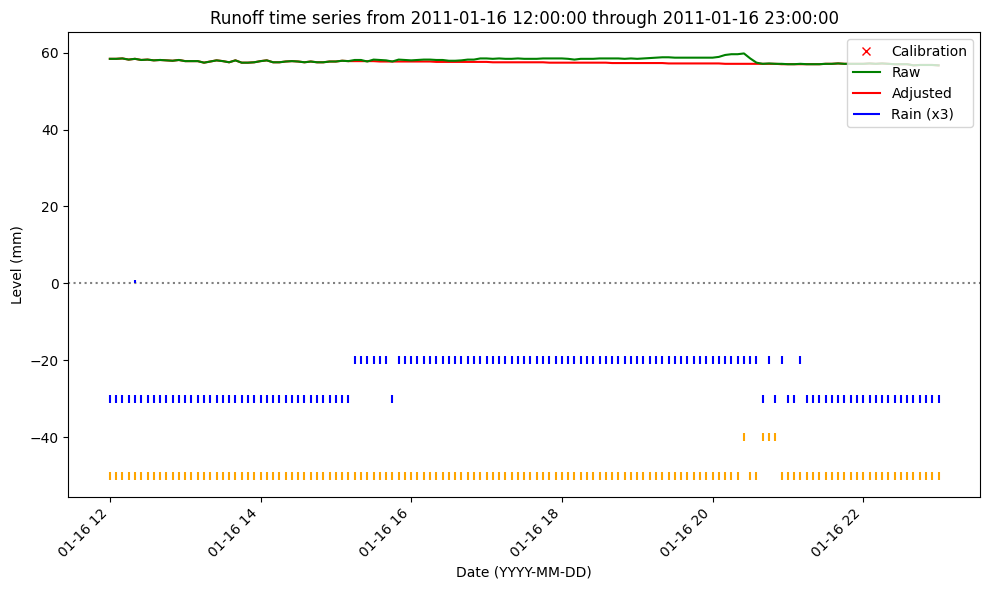

In [51]:
# plot_preds(X_val.index[0], X_val.index[-1])
# plot_preds('2016-08-01 00:00:00', '2016-08-09 00:00:00')
plot_preds('2011-01-16 12:00:00', '2011-01-16 23:00:00')

In [ ]:
# data_subset = data_united[X_val.index[0]:X_val.index[-1]]

# fig, ax = plt.subplots(figsize=(10, 6))
# plt.axhline(y=0, color ='grey', linestyle = ':')
# # Plot the rain as a bar chart with a multiplier for visibility
# ax.vlines(data_subset.index, ymin=0, ymax=data_subset['ra_rain']*3, color = 'blue', label = "Rain (x3)")
# ax.plot(data_subset.index, data_subset['level_ro'], color = 'red', label = "Adjusted")
# ax.plot(data_subset.index, data_subset['raw_ro'], color = 'green', label = "Raw")
# # Include calibration points unless otherwise specified or unless there are none in the subset
# # if include_calibration == True and not data_subset_cal.empty:
# ax.plot(data_subset.index, data_subset['weir_level_cal'], linestyle='none', marker='x', color='red', label = "Calibration")

# # Plot labels
# ax.set_xlabel("Date (YYYY-MM-DD)")
# ax.set_ylabel("Level (mm)")
# # ax.set_title('Simple Time Series Plot')
# # ax.set_title("Runoff time series from " + input_date_start + " through " + input_date_end)
# # ax.set_ylim(bottom=0) 
# # ax.grid(True)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# # Reverse the order of the legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], loc='upper right')
# # plt.legend(loc = 'upper right')
# plt.show()

# del data_subset, fig, ax, handles, labels

In [ ]:
# f1_score, precision_score, recall_score, accuracy_score
y_true = mini_val[var_of_interest].tolist()
y_pred = mini_val['pred_tf'].tolist()

# Compute the confusion matrix
# cm = confusion_matrix(mini_val[var_of_interest].tolist(), mini_val['pred_tf'].tolist())
metric_cm = confusion_matrix(y_true, y_pred)
# print("Confusion Matrix:\n", metric_cm)

# Precision
metric_precision = precision_score(y_true, y_pred)


# Recall
metric_recall = recall_score(y_true, y_pred)

# F1
# f1_score = f1_score(mini_val[var_of_interest].tolist(), mini_val['pred_tf'].tolist())
metric_f1 = f1_score(y_true, y_pred)
# print("F1:\n", metric_f1)

# Accuracy - the total number of correct predictions performed by hte model
metric_accuracy = accuracy_score(y_true, y_pred)

print(
    "\nConfusion Matrix:\n", metric_cm,
    "\nPrecision:\t", metric_precision,
    "\nRecall:\t\t", metric_recall,
    "\nF1 Score:\t", metric_f1,
    "\nAccuracy:\t", metric_accuracy
)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=metric_cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Environment cleanup
del y_true, y_pred, metric_cm, metric_precision, metric_recall, metric_f1, metric_accuracy, disp